# Imports

In [2]:
# General Imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import keras 

# Audio and Music Processing
import librosa
import librosa.display
from midiutil import MIDIFile  # http://midiutil.readthedocs.io/en/1.2.1/
import music21  # http://web.mit.edu/music21/
from music21 import (
    stream,
    instrument,
    metadata,
    key,
    harmony,
    duration,
    tempo,
    meter,
    note,
    midi,
)
from music21.tempo import MetronomeMark
from music21.note import Note, Rest
from music21.stream import Stream
from music21.key import Key

# Visualization
import IPython.display as ipd
from ipywidgets import (
    interactive_output,
    IntSlider,
    FloatSlider,
    Checkbox,
    VBox,
    Label,
    fixed,
)

# Machine Learning
from keras.models import load_model


## Configuration and Parameter Settings

In [4]:
# Path configuration
path = './audio/music/'

# Matplotlib configuration
plt.rc("figure", figsize=(16, 8))

# Signal Processing Parameters
fs = 44100                               # Sampling Frequency
nfft = 2048                              # Length of the FFT window
overlap = 0.5                            # Hop overlap percentage
hop_length = int(nfft * (1 - overlap))   # Number of samples between successive frames
n_bins = 72                              # Number of frequency bins
mag_exp = 4                              # Magnitude Exponent
pre_post_max = 6                         # Pre- and post- samples for peak picking
cqt_threshold = -61                      # Threshold for CQT dB levels, all values below threshold are set to -120 dB

## Load Model and Audio files

In [62]:
# Load the trained model
model = load_model('guitar_chord_recognition_model.keras')
print("Model loaded successfully.")

# Load the encoder and scaler
encoder = joblib.load('encoder.pkl')
scaler = joblib.load('scaler.pkl')
print("Encoder and scaler loaded successfully.")

# Chord mapping for decoding
chord_mapping = {
    0: 'A', 1: 'A#', 2: 'B', 3: 'C', 4: 'C#', 5: 'D', 6: 'D#', 7: 'E', 8: 'F', 9: 'F#', 10: 'G', 11: 'G#',
    12: 'Am', 13: 'A#m', 14: 'Bm', 15: 'Cm', 16: 'C#m', 17: 'Dm', 18: 'D#m', 19: 'Em', 20: 'Fm', 21: 'F#m',
    22: 'Gm', 23: 'G#m', 24: 'A7', 25: 'A#7', 26: 'B7', 27: 'C7', 28: 'C#7', 29: 'D7', 30: 'D#7', 31: 'E7',
    32: 'F7', 33: 'F#7', 34: 'G7', 35: 'G#7'
}

# Load Audio
filename = r'C:\Users\CJHx6\OneDrive\AI_Class\GIT\Group_3_Project\notebooks\corey_exploration\audio\music\Guns N Roses-Sweet Child O Mine Intro.wav'
x, fs = librosa.load(filename, sr=fs, mono=True, duration=12)
print(f"x Shape= {x.shape}")
print(f"Sample rate fs= {fs}")
print(f"Audio Length in seconds= {len(x) / fs:.2f} s")

# Load the song intro
audio_path = r'C:\Users\CJHx6\OneDrive\AI_Class\GIT\Group_3_Project\notebooks\corey_exploration\audio\music\Guns N Roses-Sweet Child O Mine Intro.wav'
y, sr = librosa.load(audio_path, sr=None)

# Playback audio file
ipd.Audio(filename)

Model loaded successfully.
Encoder and scaler loaded successfully.
x Shape= (529200,)
Sample rate fs= 44100
Audio Length in seconds= 12.00 s


In [7]:
ipd.Audio(audio_path)

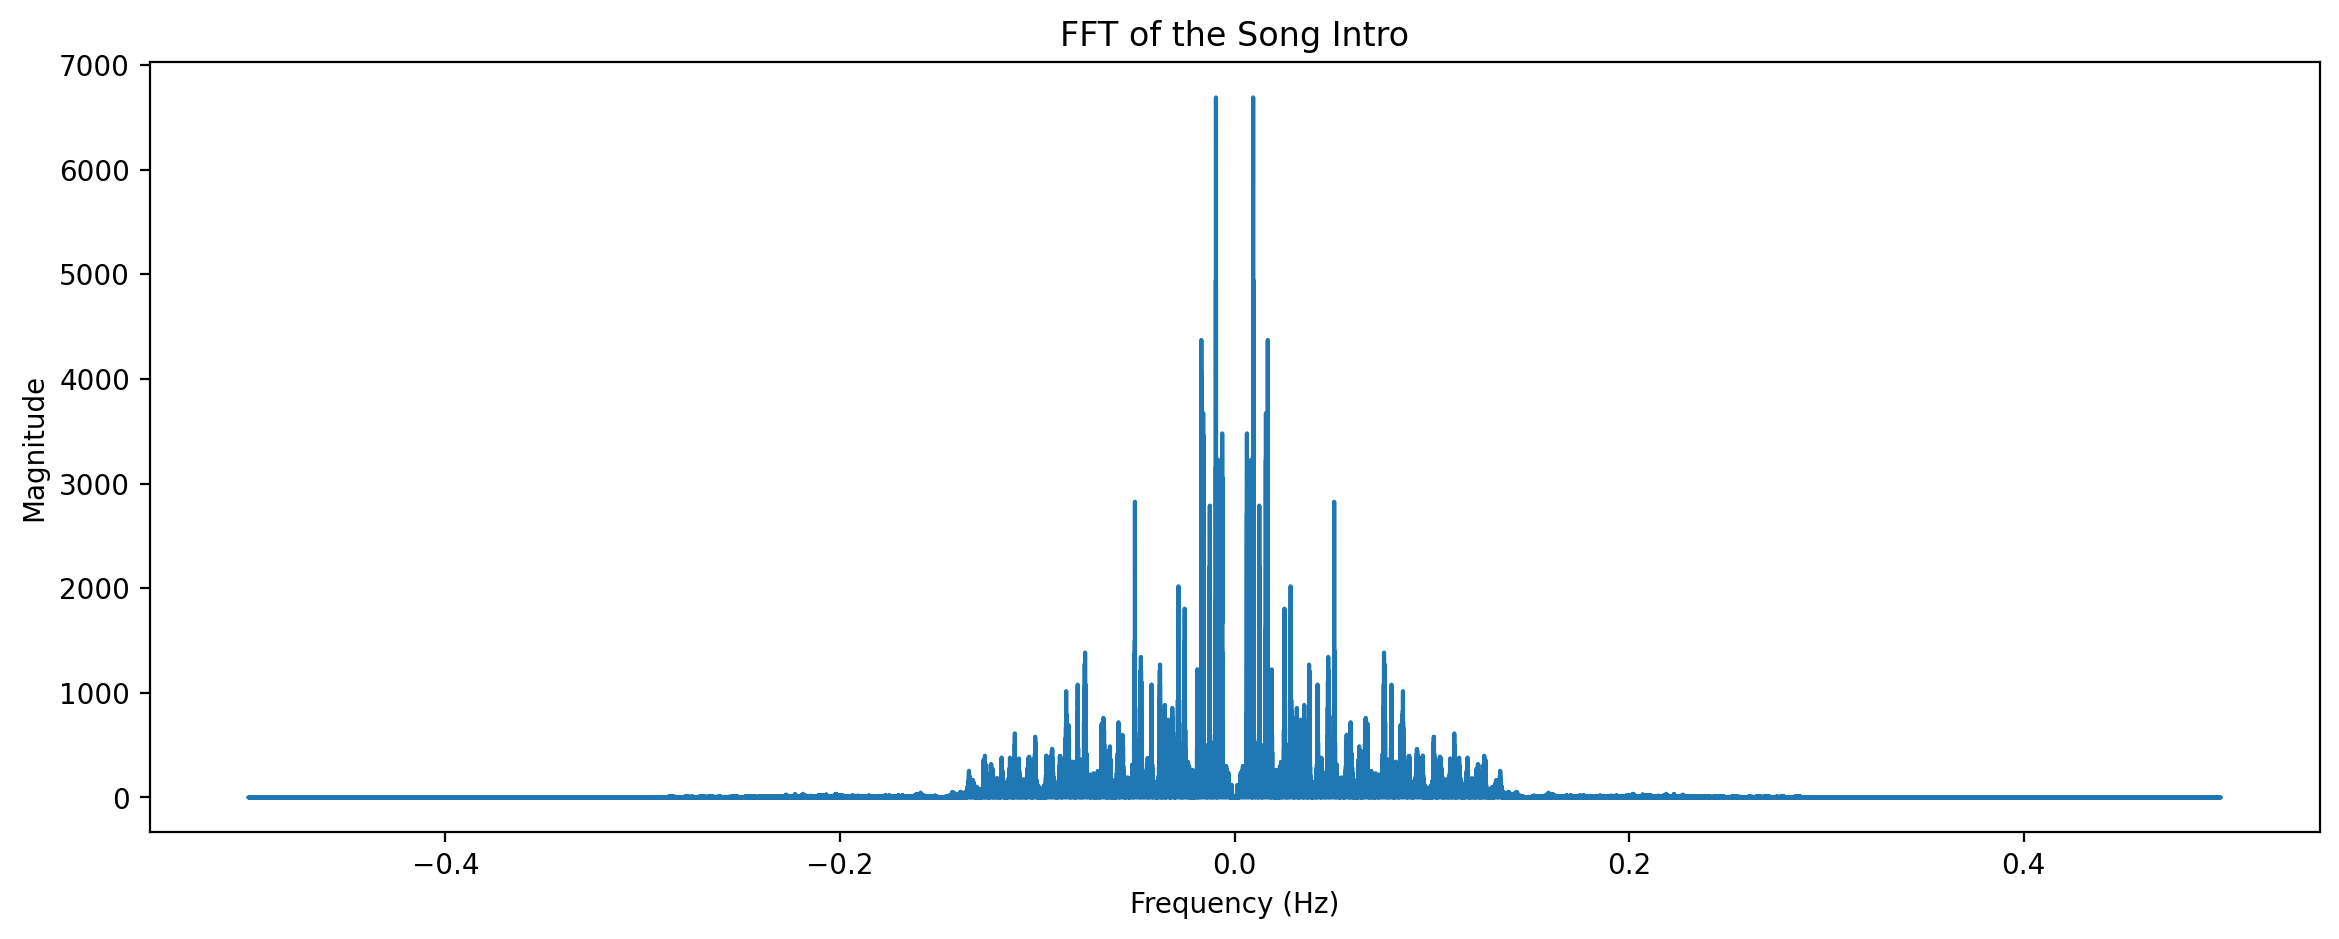

In [8]:
# Apply FFT
fft_result = np.fft.fft(y)
fft_freqs = np.fft.fftfreq(len(fft_result))

# Plot FFT
plt.figure(figsize=(14, 5))
plt.plot(fft_freqs, np.abs(fft_result))
plt.title('FFT of the Song Intro')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.show()

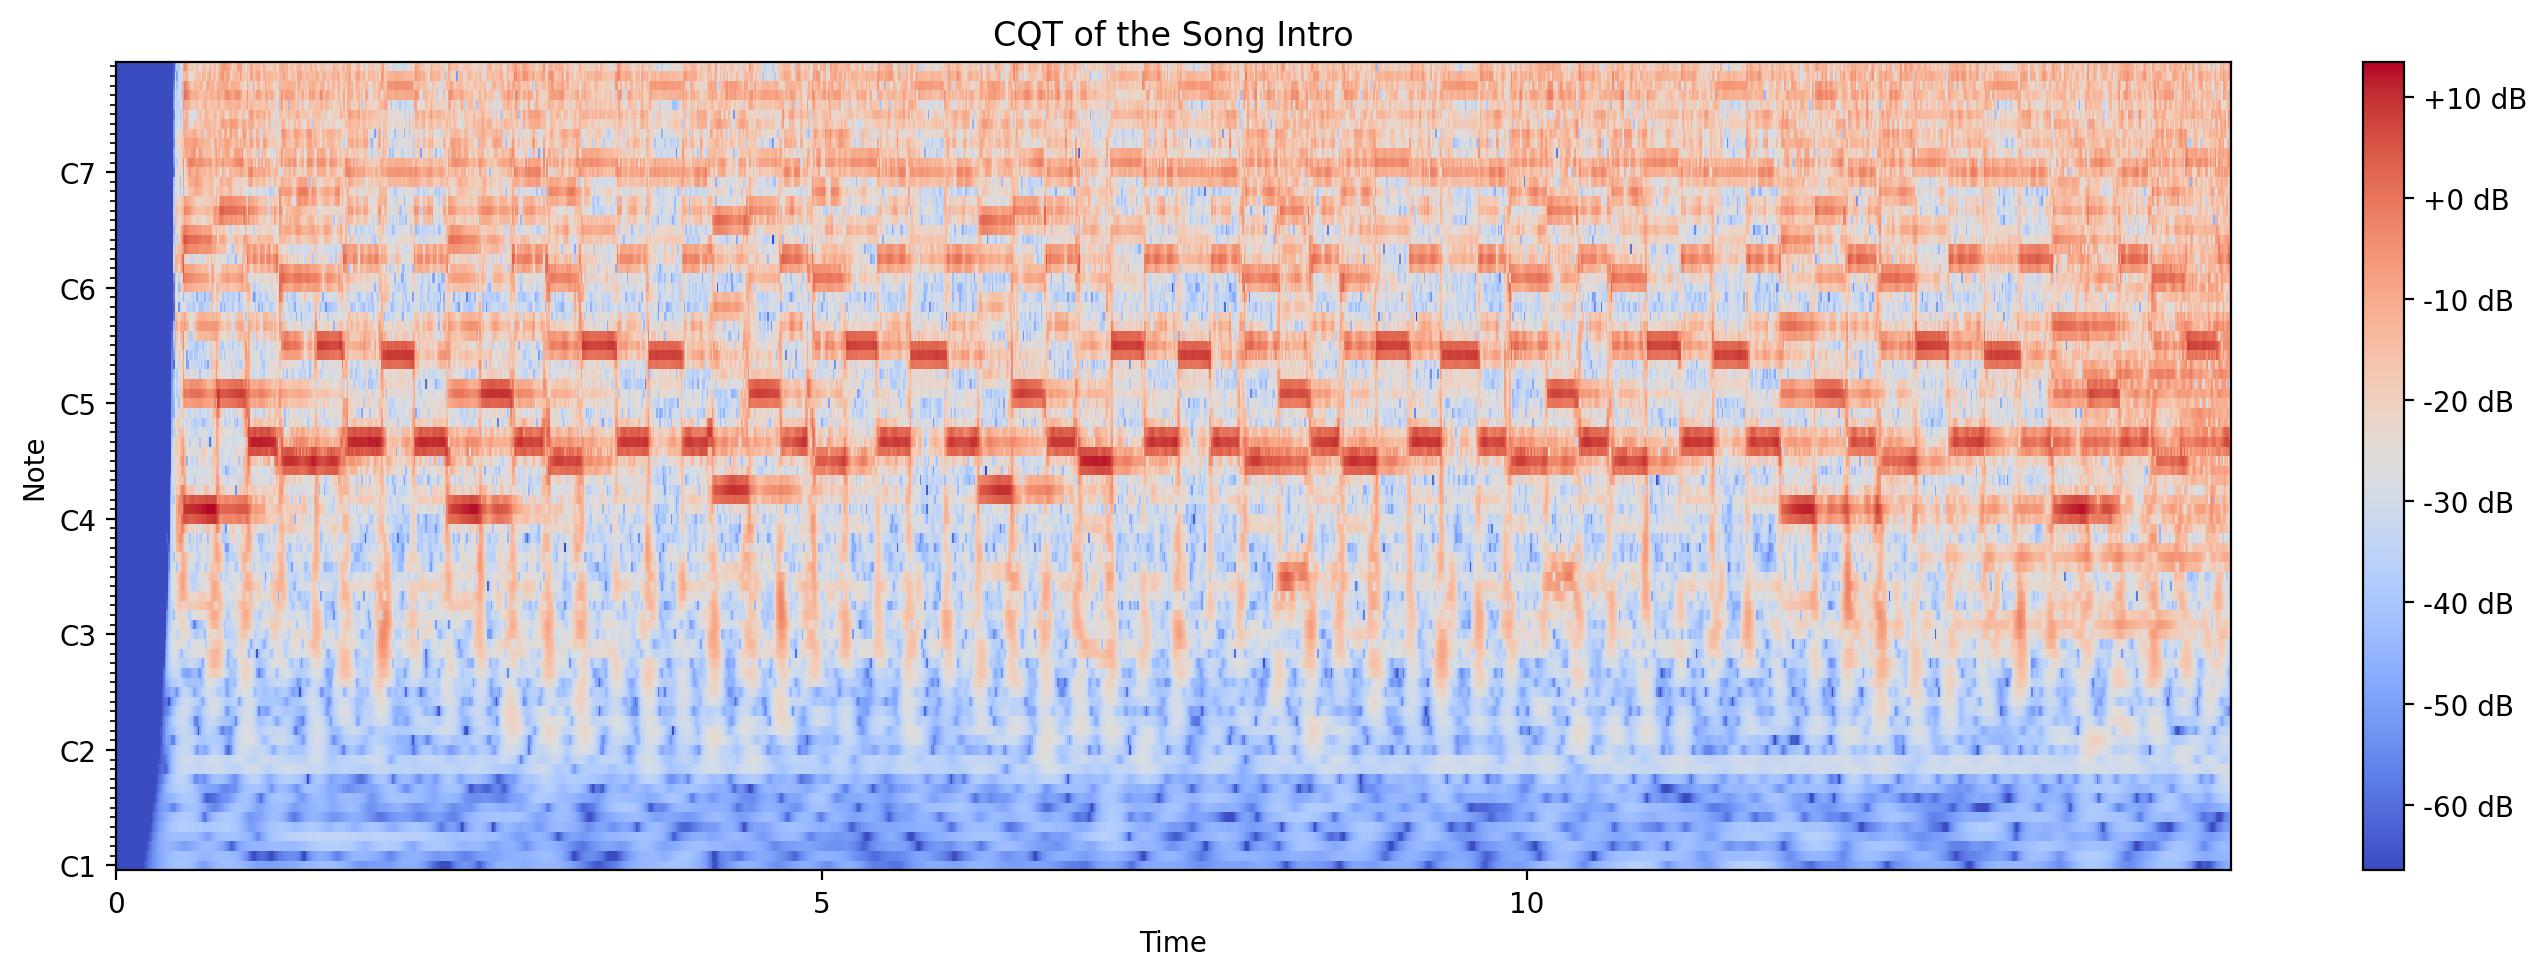

In [9]:
# Apply CQT
cqt_result = librosa.cqt(y, sr=sr)
cqt_db = librosa.amplitude_to_db(np.abs(cqt_result))

# Plot CQT
plt.figure(figsize=(14, 5))
librosa.display.specshow(cqt_db, sr=sr, x_axis='time', y_axis='cqt_note')
plt.colorbar(format='%+2.0f dB')
plt.title('CQT of the Song Intro')
plt.tight_layout()
plt.show()

In [10]:
# Segment the audio
segment_length = 16000  # 1-second segments at 16kHz
segments = [y[i:i + segment_length] for i in range(0, len(y), segment_length)]

## Predict Chords

In [11]:
# Predict chords for each segment
for i, segment in enumerate(segments):
    # Ensure segment is of correct length
    if len(segment) < segment_length:
        segment = np.pad(segment, (0, max(0, segment_length - len(segment))), mode='constant')

    # Expand dimensions to match input shape (batch_size, steps, channels)
    segment = np.expand_dims(segment, axis=-1)  # Add channel dimension
    segment = np.expand_dims(segment, axis=0)  # Add batch dimension

    # Predict the chord
    prediction = model.predict(segment)
    predicted_chord = np.argmax(prediction)

    # Decode the predicted chord number to chord name
    chord_name = chord_mapping[predicted_chord]

    # Print the predicted chord name
    print(f'Segment {i+1}: Predicted Chord: {chord_name}')



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
Segment 1: Predicted Chord: F#7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Segment 2: Predicted Chord: C
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Segment 3: Predicted Chord: B7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Segment 4: Predicted Chord: G
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Segment 5: Predicted Chord: G
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Segment 6: Predicted Chord: A#m
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Segment 7: Predicted Chord: G#
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Segment 8: Predicted Chord: B7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Segment 9: Predicted Chord: D
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Segment 10: Predicted Chord: G#
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Segment 11: Predicted Chord: A#m
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Segment 12: Predicted Chord: C
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Segment 13: Predicted Chord: C
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Segment 14: Predicted Chord: Cm
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms

# CQT and FFT processing

Threshold for CQT dB levels, all values below threshold are set to -120 dB

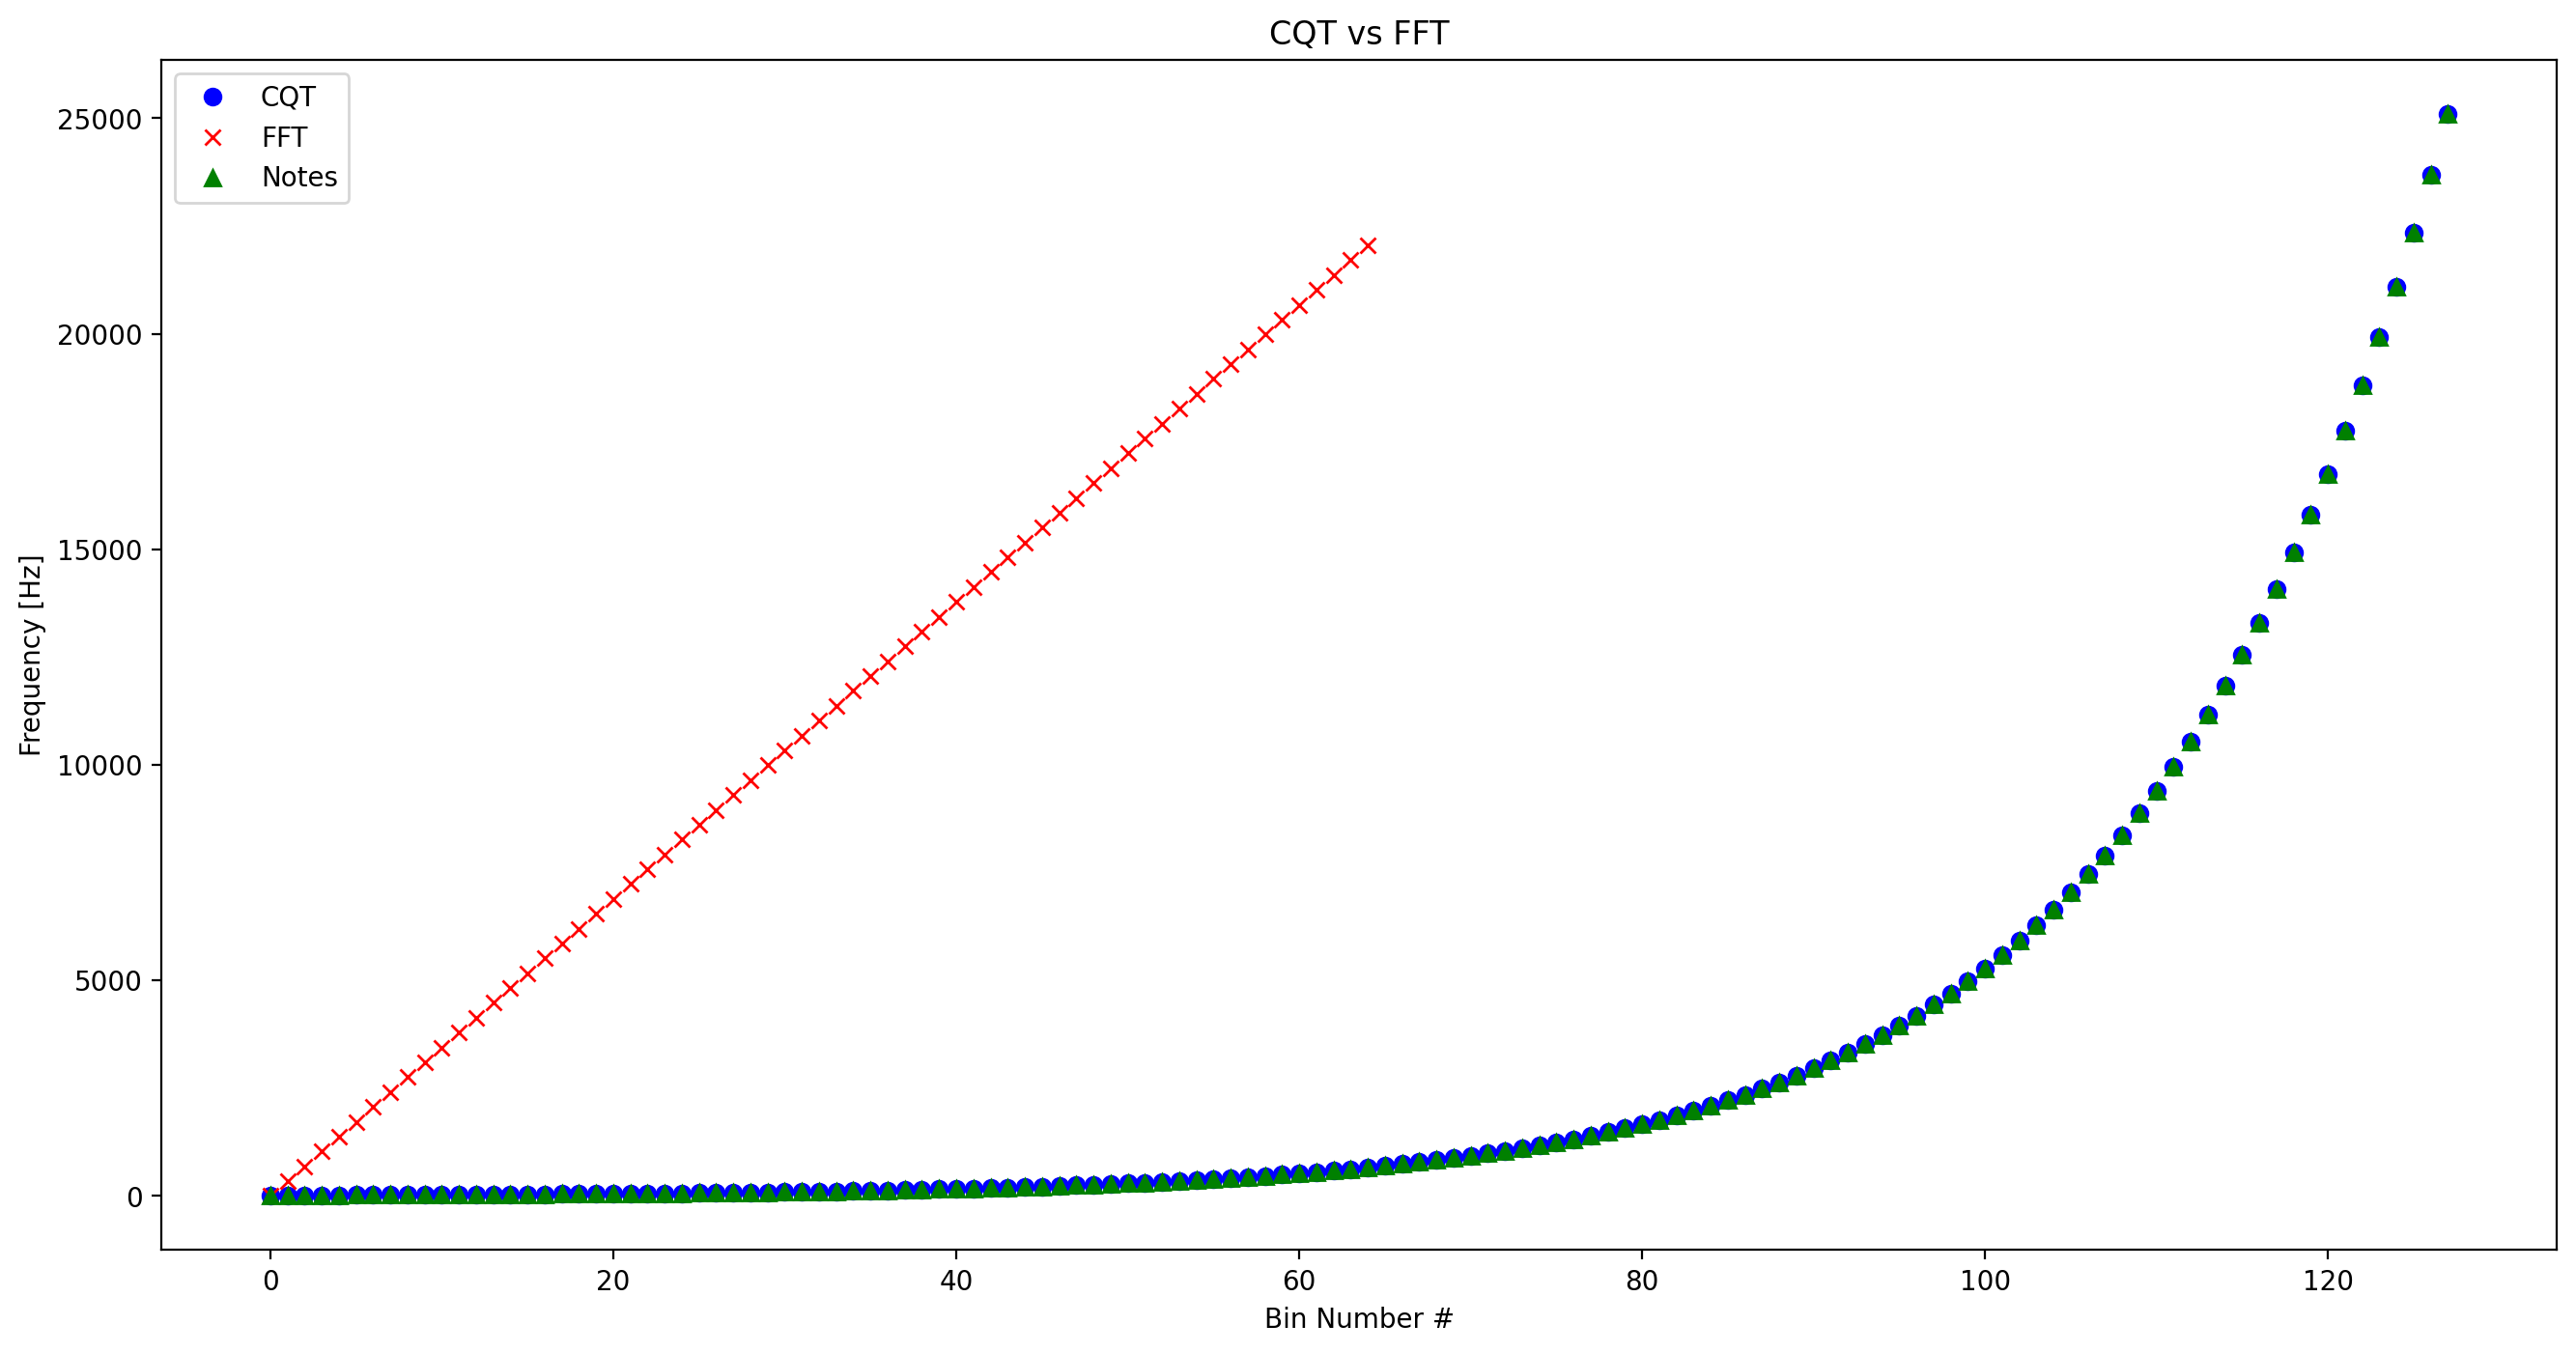

In [14]:
# CQT vs FFT
cqt_freqs = librosa.core.cqt_frequencies(n_bins=128, fmin=librosa.note_to_hz('C0'), bins_per_octave=12)
fft_freqs = librosa.fft_frequencies(sr=fs, n_fft=128)
notes_freqs = 440 * 2 ** (np.arange(-57, (128 - 57)) / 12)

# Plot CQT vs FFT
plt.figure()
plt.plot(cqt_freqs, 'bo', label='CQT')
plt.plot(fft_freqs, 'rx', label='FFT')
plt.plot(notes_freqs, 'g^', label='Notes')
plt.title("CQT vs FFT")
plt.xlabel('Bin Number #')
plt.ylabel('Frequency [Hz]')
plt.legend()
plt.show()

In [15]:
# CQT function
def calc_cqt(x, fs=fs, hop_length=hop_length, n_bins=n_bins, mag_exp=mag_exp):
    C = librosa.cqt(x, sr=fs, hop_length=hop_length, fmin=None, n_bins=n_bins)
    C_mag = librosa.magphase(C)[0] ** mag_exp
    CdB = librosa.core.amplitude_to_db(C_mag, ref=np.max)
    return CdB

# CQT Threshold function
def cqt_thresholded(cqt, thres=cqt_threshold):
    new_cqt = np.copy(cqt)
    new_cqt[new_cqt < thres] = -120
    return new_cqt

# Onset Envelope from CQT
def calc_onset_env(cqt):
    return librosa.onset.onset_strength(S=cqt, sr=fs, aggregate=np.mean, hop_length=hop_length)

# Onset from Onset Envelope
def calc_onset(cqt, pre_post_max=pre_post_max, backtrack=True):
    onset_env = calc_onset_env(cqt)
    onset_frames = librosa.onset.onset_detect(onset_envelope=onset_env, sr=fs, units='frames', 
                                              hop_length=hop_length, backtrack=backtrack, pre_max=pre_post_max, 
                                              post_max=pre_post_max)
    onset_boundaries = np.concatenate([[0], onset_frames, [cqt.shape[1]]])
    onset_times = librosa.frames_to_time(onset_boundaries, sr=fs, hop_length=hop_length)
    return onset_times, onset_boundaries, onset_env

# Tuning

In [17]:
# Fine Tuning UI
style = {'description_width': 'initial'}
mag_exp_slider = IntSlider(value=mag_exp, min=1, max=32, step=1, description='mag_exp:', continuous_update=False)
thres_slider = IntSlider(value=cqt_threshold, min=-120, max=0, step=1, description='Threshold:', continuous_update=False)
pre_post_slider = IntSlider(value=pre_post_max, min=1, max=32, step=1, description='Pre_post_max:', continuous_update=False, style=style)
backtrack_box = Checkbox(value=False, description='backtrack', disabled=False)

def inter_cqt_tuning(mag_exp, thres, pre_post_max, backtrack):
    thres = thres_slider.value
    mag_exp = mag_exp_slider.value
    pre_post_max = pre_post_slider.value
    backtrack = backtrack_box.value
    global CdB
    CdB = calc_cqt(x, fs, hop_length, n_bins, mag_exp)
    plt.figure()
    new_cqt = cqt_thresholded(CdB, thres)
    librosa.display.specshow(new_cqt, sr=fs, hop_length=hop_length, x_axis='time', y_axis='cqt_note', cmap='coolwarm')
    plt.ylim([librosa.note_to_hz('B2'), librosa.note_to_hz('B6')])
    global onsets
    onsets = calc_onset(new_cqt, pre_post_max, backtrack)
    plt.vlines(onsets[0], 0, fs / 2, color='k', alpha=0.8)
    plt.title("CQT - Sweet Child O' Mine Intro")
    plt.colorbar()
    plt.show()

out = interactive_output(inter_cqt_tuning, {'mag_exp': mag_exp_slider, 'thres': thres_slider, 'pre_post_max': pre_post_slider, 'backtrack': backtrack_box})
ui = VBox([mag_exp_slider, thres_slider, pre_post_slider, backtrack_box])
display(ui, out)

Output()

# Tempo

In [19]:
# Estimate Tempo
tempo, beats = librosa.beat.beat_track(y=None, sr=fs, onset_envelope=onsets[2], hop_length=hop_length, start_bpm=120.0, tightness=100, trim=True, bpm=None, units='frames')

# If tempo is an array, extract the first value
if isinstance(tempo, (list, np.ndarray)):
    tempo = tempo[0]

# Ensure tempo is rounded to the nearest even integer
tempo = int(2 * round(float(tempo) / 2))

# Create a MetronomeMark object
mm = MetronomeMark(referent='quarter', number=tempo)

# Convert seconds to quarter-notes
def time_to_beat(duration, tempo):
    return (tempo * duration / 60)

# Create Sineave

In [21]:
# Remap input to 0-1 for Sine Amplitude or to 0-127 for MIDI
def remap(x, in_min, in_max, out_min, out_max):
    return (x - in_min) * (out_max - out_min) / (in_max - in_min) + out_min

# Generate Sinewave, MIDI Notes, and music21 notes
def generate_sine_midi_note(f0_info, sr, n_duration, round_to_sixtenth=True):
    f0 = f0_info[0]
    A = remap(f0_info[1], CdB.min(), CdB.max(), 0, 1)
    duration = librosa.frames_to_time(n_duration, sr=fs, hop_length=hop_length)
    
    # Generate Midi Note and music21 Note
    note_duration = 0.02 * np.around(duration / 2 / 0.02)  # Round to 2 decimal places for music21 compatibility
    midi_duration = time_to_beat(duration, tempo)
    midi_velocity = int(round(remap(f0_info[1], CdB.min(), CdB.max(), 0, 127)))
    
    if round_to_sixtenth:
        midi_duration = round(midi_duration * 16) / 16
    
    if f0 is None or f0 == 0:
        midi_note = None
        note_info = note.Rest(type=mm.secondsToDuration(note_duration).type)
        f0 = 0
    else:
        try:
            midi_note = round(librosa.hz_to_midi(f0))
            note_name = librosa.midi_to_note(midi_note).replace('♯', '#').replace('♭', 'b')
            n = note.Note(note_name, type=mm.secondsToDuration(note_duration).type)
            n.volume.velocity = midi_velocity
            note_info = [n]
        except Exception as e:
            print(f"Error creating music21 Note: {e}")
            midi_note = None
            note_info = note.Rest(type=mm.secondsToDuration(note_duration).type)
    midi_info = [midi_note, midi_duration, midi_velocity]

       
    
    # Generate Sinewave
    n = np.arange(librosa.frames_to_samples(n_duration, hop_length=hop_length))
    sine_wave = A * np.sin(2 * np.pi * f0 * n / float(sr))
    
    return [sine_wave, midi_info, note_info]

# Estimate Pitch

In [23]:
# Estimate Pitch
def estimate_pitch(segment, threshold):
    freqs = librosa.cqt_frequencies(n_bins=n_bins, fmin=librosa.note_to_hz('C1'),
                                    bins_per_octave=12)
    if segment.max() < threshold:
        return [None, np.mean((np.amax(segment, axis=0)))]
    else:
        f0 = int(np.mean((np.argmax(segment, axis=0))))
    return [freqs[f0], np.mean((np.amax(segment, axis=0)))]

# Generate notes from Pitch estimation
def estimate_pitch_and_notes(x, onset_boundaries, i, sr):
    n0 = onset_boundaries[i]
    n1 = onset_boundaries[i + 1]
    f0_info = estimate_pitch(np.mean(x[:, n0:n1], axis=1), threshold=cqt_threshold)
    return generate_sine_midi_note(f0_info, sr, n1 - n0)

# Create Notes

In [25]:
# Array of music information - Sinewave, MIDI Notes, and music21 Notes
music_info = [
    estimate_pitch_and_notes(CdB, onsets[1], i, sr=fs)
    for i in range(len(onsets[1]) - 1)
]

# Extract sinewave data from each entry
synth_audio = np.concatenate([entry[0] for entry in music_info])

# Extract music21 note information from each entry
note_info = [entry[2] for entry in music_info]

In [26]:
# Play generated sinewave
ipd.Audio(synth_audio, rate=fs)

# Create Stream

In [28]:
# Create music21 stream
s = stream.Stream()
s.append(mm)
electricguitar = instrument.fromString('electric guitar')
electricguitar.midiChannel = 0
electricguitar.midiProgram = 30  # Set program to Overdriven Guitar
s.append(electricguitar)
s.insert(0, metadata.Metadata())
s.metadata.title = "Sweet Child O' Mine - Introduction"
s.metadata.composer = "Guns n' Roses"
for n in note_info:
    s.append(n)

# Analyze music21 stream to get song Key
key = s.analyze('key')
print(key.name)
# Insert Key to Stream
s.insert(0, key)

C# major


{0.0} <music21.metadata.Metadata object at 0x1c2e3b571d0>
{0.0} <music21.instrument.ElectricGuitar 'electric guitar'>
{0.0} <music21.tempo.MetronomeMark allegro moderato Quarter=130>
{0.0} <music21.key.Key of C# major>
{0.0} <music21.note.Rest quarter>
{1.0} <music21.note.Note C#>
{1.5} <music21.note.Note C#>
{1.75} <music21.note.Note G#>
{2.25} <music21.note.Note F#>
{2.75} <music21.note.Note F#>
{3.0} <music21.note.Note G#>
{3.5} <music21.note.Note F>
{4.0} <music21.note.Note G#>
{4.5} <music21.note.Note C#>
{5.0} <music21.note.Note C#>
{5.5} <music21.note.Note G#>
{6.0} <music21.note.Note F#>
{6.5} <music21.note.Note F#>
{7.0} <music21.note.Note G#>
{7.5} <music21.note.Note F>
{8.0} <music21.note.Note G#>
{8.25} <music21.note.Note D#>
{8.75} <music21.note.Note C#>
{9.0} <music21.note.Note G#>
{9.5} <music21.note.Note F#>
{10.0} <music21.note.Note F#>
{10.5} <music21.note.Note G#>
{11.0} <music21.note.Note F>
{11.5} <music21.note.Note G#>
{12.0} <music21.note.Note D#>
{12.5} <music21

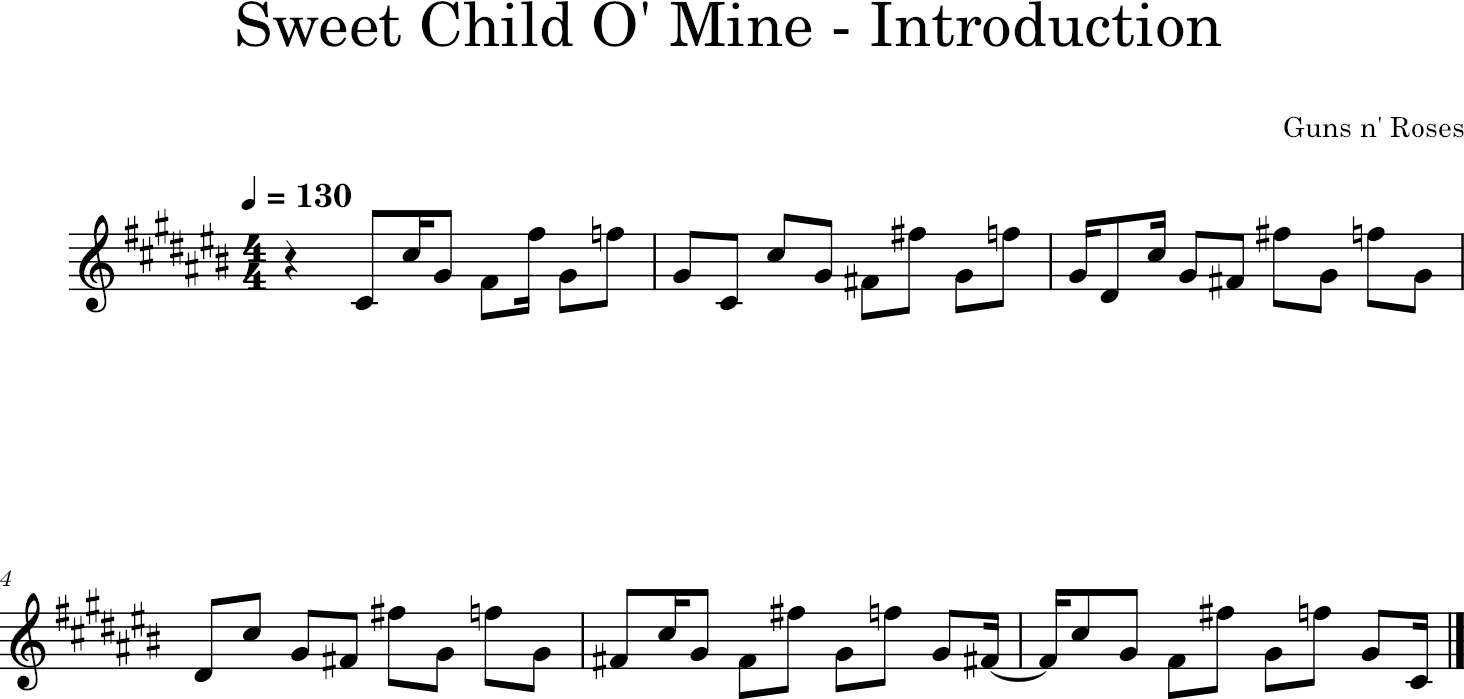

In [29]:
# Show stream as text
s.show('text')

# Listen to music21 stream as MIDI
s.show('midi')

# Show notes
s.show()

# Chord Prediction

In [31]:
# Segment audio based on onsets for chord prediction
segments = []
for i in range(len(onsets[1]) - 1):
    start = onsets[1][i] * hop_length
    end = onsets[1][i + 1] * hop_length
    segment = x[start:end]
    segment = librosa.util.fix_length(segment, size=16000)
    segments.append(segment)

In [32]:
predicted_chords = []
for i, segment in enumerate(segments):
    segment = np.expand_dims(segment, axis=-1)
    segment = np.expand_dims(segment, axis=0)
    prediction = model.predict(segment)
    predicted_chord = np.argmax(prediction)
    chord_name = chord_mapping[predicted_chord]
    duration_in_quarters = time_to_beat(len(segment[0]) / fs, tempo)
    predicted_chords.append((chord_name, duration_in_quarters))
    print(f'Segment {i + 1}: Predicted Chord: {chord_name}, Duration: {duration_in_quarters:.2f} quarters')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Segment 1: Predicted Chord: F#7, Duration: 0.79 quarters
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Segment 2: Predicted Chord: Dm, Duration: 0.79 quarters
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Segment 3: Predicted Chord: C, Duration: 0.79 quarters
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Segment 4: Predicted Chord: Dm, Duration: 0.79 quarters
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Segment 5: Predicted Chord: Dm, Duration: 0.79 quarters
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Segment 6: Predicted Chord: Gm, Duration: 0.79 quarters
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Segment 7: Predicted Chord: G#7, Duration: 0.79 quarters
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Segment 8: Predicted Chord: G#, Duration: 0.79 quarters
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Segment 9: Predicted Chord: G#, Duration: 0.79 quarters
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Segment 10: Predicted Chord: E, Duration: 0.79 quarters
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Segment 11: Predicted

# Create Stream

In [34]:
# Create music21 stream
s = stream.Stream()
s.append(mm)
electricguitar = instrument.fromString('electric guitar')
electricguitar.midiChannel = 0
electricguitar.midiProgram = 30  # Set program to Overdriven Guitar
s.append(electricguitar)
s.insert(0, metadata.Metadata())
s.metadata.title = "Sweet Child O' Mine - Introduction"
s.metadata.composer = "Guns n' Roses"

# Add notes to the stream
for n in note_info:
    s.append(n)

# Integrate chord predictions into the stream
for chord_name, dur in predicted_chords:
    chord_symbol = harmony.ChordSymbol(chord_name)
    chord_symbol.quarterLength = dur
    s.append(chord_symbol)

A- major
{0.0} <music21.metadata.Metadata object at 0x1c2e7e9bef0>
{0.0} <music21.instrument.ElectricGuitar 'electric guitar'>
{0.0} <music21.tempo.MetronomeMark allegro moderato Quarter=130>
{0.0} <music21.key.Key of A- major>
{0.0} <music21.note.Rest quarter>
{1.0} <music21.note.Note C#>
{1.5} <music21.note.Note C#>
{1.75} <music21.note.Note G#>
{2.25} <music21.note.Note F#>
{2.75} <music21.note.Note F#>
{3.0} <music21.note.Note G#>
{3.5} <music21.note.Note F>
{4.0} <music21.note.Note G#>
{4.5} <music21.note.Note C#>
{5.0} <music21.note.Note C#>
{5.5} <music21.note.Note G#>
{6.0} <music21.note.Note F#>
{6.5} <music21.note.Note F#>
{7.0} <music21.note.Note G#>
{7.5} <music21.note.Note F>
{8.0} <music21.note.Note G#>
{8.25} <music21.note.Note D#>
{8.75} <music21.note.Note C#>
{9.0} <music21.note.Note G#>
{9.5} <music21.note.Note F#>
{10.0} <music21.note.Note F#>
{10.5} <music21.note.Note G#>
{11.0} <music21.note.Note F>
{11.5} <music21.note.Note G#>
{12.0} <music21.note.Note D#>
{12.5}

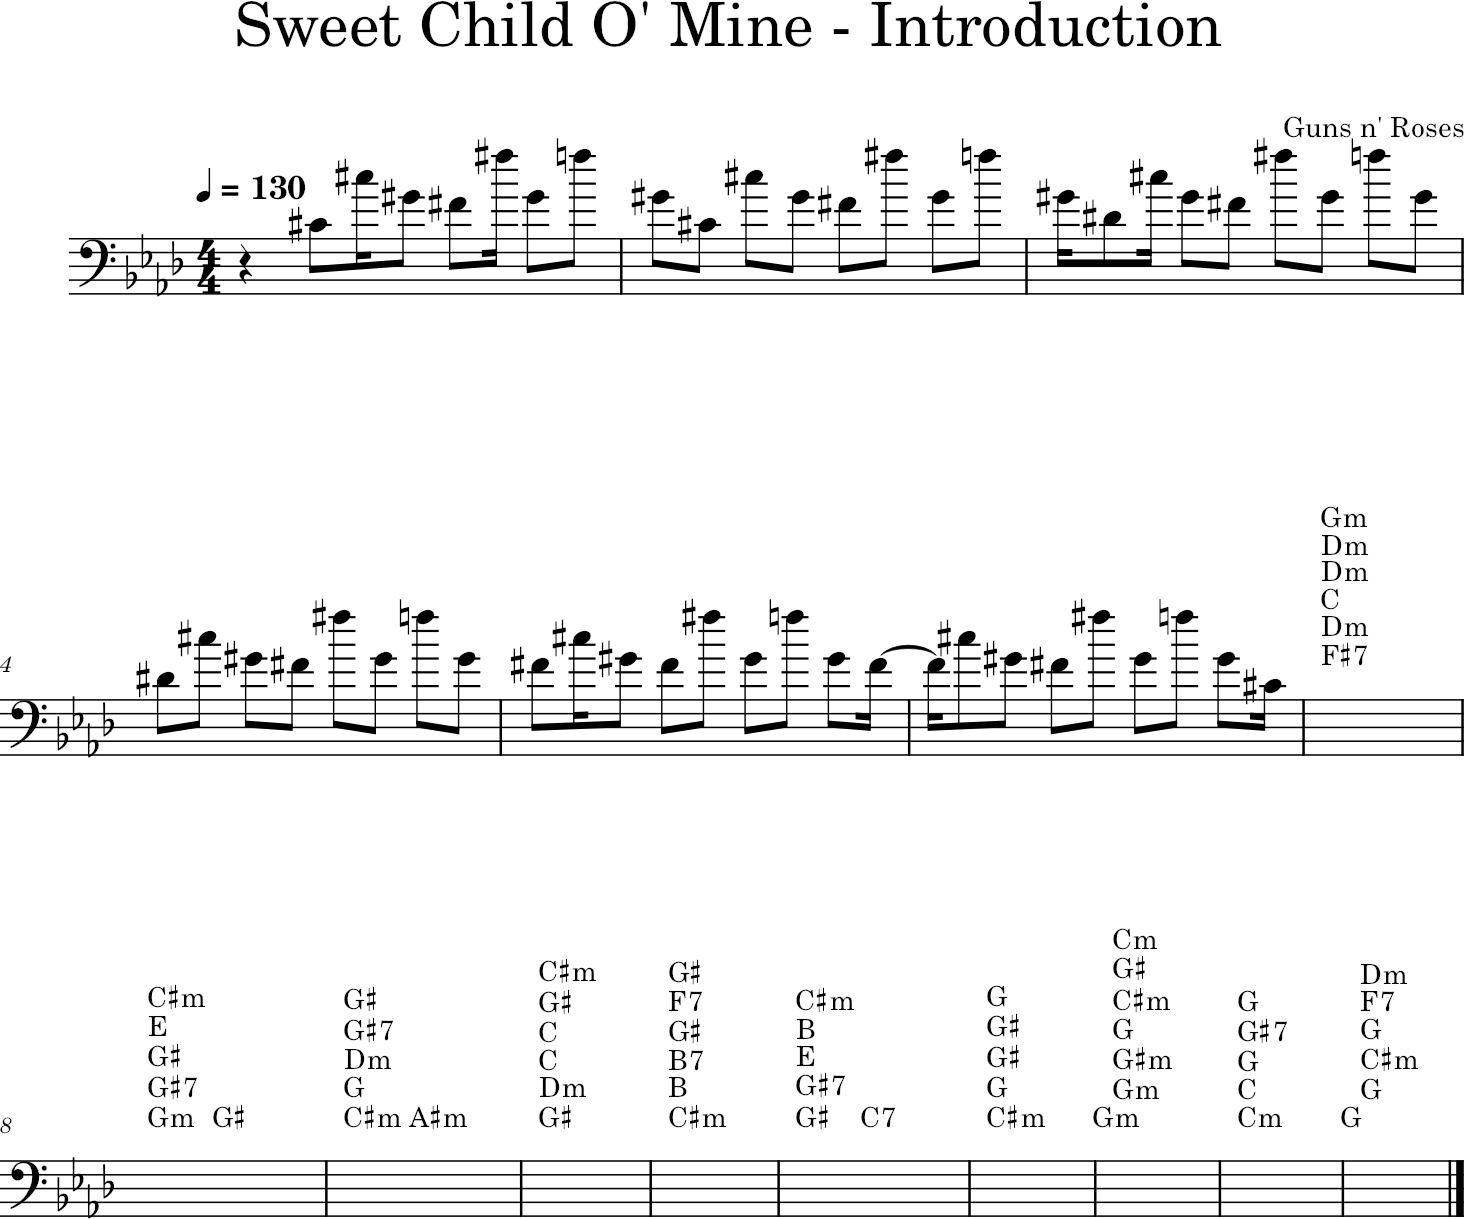

In [35]:
# Analyze music21 stream to get song Key
key = s.analyze('key')
print(key.name)
# Insert Key to Stream
s.insert(0, key)

# Display music21 stream

# Show stream as text
s.show('text')

# Listen to music21 stream as MIDI
s.show('midi')

# Display sheet music
s.show()

In [36]:

# Save MIDI to file
s.write('midi', 'sweet_child_music21_with_chords.mid')

# Extract MIDI information from each entry
midi_info = [entry[1] for entry in music_info]

# Save MIDI file from MIDI information using MIDIUtils - not using anything from music21
track = 0
channel = 0
tempo = tempo  # In BPM
volume = 100  # 0-127, as per the MIDI standard

gnr = MIDIFile(1)  # One track, defaults to format 1 (tempo track is created automatically)
gnr.addTrackName(0, 0, "Guns n' Roses - Sweet Child O' Mine - Intro")
program = 30  # Overdriven Guitar
gnr.addProgramChange(track, channel, 0, program)
gnr.addTempo(track, 0, tempo)

note_time = 0
for i, note in enumerate(midi_info):
    if note[0] is None:
        note_time += note[1]
    else:
        note_time += note[1]
        gnr.addNote(track, channel, int(note[0]), note_time, note[1], note[2])

with open("sweet_child_midiutils_with_chords.mid", "wb") as output_file:
    gnr.writeFile(output_file)

# Set the MuseScore executable path
music21.environment.set('musescoreDirectPNGPath', r'C:\Program Files\MuseScore 4\bin\MuseScore4.exe')

# Verify the path is set correctly
print(music21.environment.get('musescoreDirectPNGPath'))

# Save sheet music as PNG
png_filename = 'sweet_child_music21_with_chords.png'
s.write(fmt='musicxml.png', fp=png_filename)

# Display the PNG
from IPython.display import Image
Image(png_filename)


C:\Program Files\MuseScore 4\bin\MuseScore4.exe


FileNotFoundError: No such file or directory: 'sweet_child_music21_with_chords.png'

FileNotFoundError: No such file or directory: 'sweet_child_music21_with_chords.png'

<IPython.core.display.Image object>